In [2]:
import numpy as np 
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from warnings import filterwarnings
from pandas.tseries.offsets import YearEnd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

filterwarnings('ignore')

# 데이터 전처리

In [3]:
df_ret = pd.read_pickle('./DATA/real_ret.pkl')
df_cap  = pd.read_pickle('./DATA/kospi_capital.pkl').astype(float)
df_eq = pd.read_pickle('./DATA/check.pickle')
df_info = pd.read_pickle('./DATA/real_kospi_info.pkl')
df_code = pd.read_pickle('./DATA/real_kospi_code.pkl')

rf = pd.read_csv('./DATA/CD91.csv', index_col=0, parse_dates=True).apply(lambda x : x/100).resample('m').last()

In [21]:
df_ret

,005930,373220,000660,207940,051910,006400,005380,035420,000270,005490,...,114410,117930,121910,122290,122750,138250,144620,152330,192520,192530
1980-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,0.1031,0.1963,0.1800,-0.0341,0.1500,0.1591,0.1060,0.1408,0.1265,0.0868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28,-0.0066,0.0038,0.0102,-0.0252,-0.0145,0.0161,0.0557,0.0296,0.1272,0.0582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,0.0621,0.1166,-0.0056,0.0194,0.0471,0.0560,0.0465,-0.0312,0.0757,0.1658,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-30,0.0234,-0.0051,0.0102,-0.0089,0.0393,-0.0599,0.0705,-0.0480,0.0432,0.0245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 수익률

일간 수익률을 통해 비정상적인 값을 수정함. <br>

러프하게 수정하지 않고 돌리는게 나을지도? (1년간의 모멘텀을 보고 투자한다고 가정 할 때 NaN값이 걸릴수도 있지 않을까?)

위에가 일간 필터링이고 <br>

아래는 걍 Close resample last 이용 해서 해버리기 

In [8]:
# df_close_daily = df.loc[:, (slice(None), '종가')].copy()
# df_close_daily.columns = df_close_daily.columns.get_level_values(0)

# df_close_daily = df.copy()

# df_close_ret = np.log(df_close_daily.astype(float)).diff().iloc[1:].copy()

# df_close_ret.loc[:'1995-03'] = np.where(abs(df_close_ret.loc[:'1995-03']) > 0.041, np.NaN, df_close_ret.loc[:'1995-03'])
# df_close_ret.loc['1995-04':'1996-10'] = np.where(abs(df_close_ret.loc['1995-04':'1996-10']) > 0.061, np.NaN, df_close_ret.loc['1995-04':'1996-10'])
# df_close_ret.loc['1996-11':'1998-02'] = np.where(abs(df_close_ret.loc['1996-11':'1998-02']) > 0.081, np.NaN, df_close_ret.loc['1996-11':'1998-02'])
# df_close_ret.loc['1998-03':'1998-11'] = np.where(abs(df_close_ret.loc['1998-03':'1998-11']) > 0.121, np.NaN, df_close_ret.loc['1998-03':'1998-11'])
# df_close_ret.loc['1998-12':'2015-05'] = np.where(abs(df_close_ret.loc['1998-12':'2015-05']) > 0.151, np.NaN, df_close_ret.loc['1998-12':'2015-05'])
# df_close_ret.loc['2015-06':] = np.where(abs(df_close_ret.loc['2015-06':]) > 0.301, np.NaN, df_close_ret.loc['2015-06':])

# df_close_ret

df_ret = df_ret * df_info.replace('유가증권시장', 1).replace('비상장', np.NaN).replace('코스닥', np.NaN).replace('K-OTC', np.NaN).astype(float)
df_ret = df_ret * pd.DataFrame(np.where(df_code == 'K', 0, 1.0), index=df_code.index, columns=df_code.columns)

mom_ret = df_ret.shift(1).rolling(11).apply(lambda x: (1+x).prod()-1)
monthly_ret = df_ret

In [17]:
#mom_ret     = df_close_daily.resample('m').last().shift(1).pct_change(11).iloc[12:].replace(0, np.NaN)
#monthly_ret = df_close_daily.resample('m').last().pct_change().iloc[1:].replace(0, np.NaN)

pnl_ret_list  = []
ivst_idx_list = []
long_tick_list = []
short_tick_list = []
s_ret_list = []
l_ret_list = []

for num in range(len(mom_ret)-1):
    series = mom_ret.iloc[num].dropna()

    date_idx = series.name
    ivst_idx = monthly_ret.index[np.where(monthly_ret.index==date_idx)[0][0] + 1]

    long_tick = series[series > series.quantile(0.9)].index.to_list()
    short_tick = series[series < series.quantile(0.1)].index.to_list()
    #short_tick = series[series < series.quantile(0.2)].index.to_list()

    long_ret = monthly_ret.loc[ivst_idx, long_tick].mean()
    short_ret = monthly_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret = monthly_ret.loc[ivst_idx, long_tick].mean() - monthly_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret_list.append(pnl_ret)
    ivst_idx_list.append(ivst_idx)
    long_tick_list.append(long_tick)
    short_tick_list.append(short_tick)
    s_ret_list.append(short_ret)
    l_ret_list.append(long_ret)
    

mom_pnl = pd.DataFrame(index=ivst_idx_list, \
                       data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                       columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

In [5]:
mom_pnl

,mom_pnl,long_idx,short_idx,s_ret,l_ret
1990-07-31,-0.007014,"[005930, 006400, 012450, 010620, 004990, 00341...","[000810, 005830, 003690, 003540, 005610, 00595...",-0.049568,-0.056583
1990-08-31,0.080136,"[004020, 010620, 004990, 003410, 004000, 01078...","[000810, 006800, 005940, 003690, 009970, 00354...",-0.098677,-0.018541
1990-09-30,0.015305,"[012450, 004020, 010620, 004990, 006260, 00238...","[000810, 006800, 005940, 001450, 003690, 00354...",-0.052894,-0.037589
1990-10-31,-0.256456,"[012330, 004020, 010620, 004990, 006260, 00400...","[000810, 006800, 005940, 001450, 003690, 00354...",0.266761,0.010306
1990-11-30,-0.032554,"[012330, 004020, 010620, 004990, 014680, 00626...","[000810, 006800, 005940, 001450, 006280, 00369...",0.023876,-0.008678
...,...,...,...,...,...
2023-02-28,0.036907,"[003670, 032830, 033780, 009830, 012450, 00507...","[377300, 361610, 302440, 251270, 000990, 02015...",-0.015377,0.02153
2023-03-31,0.144131,"[373220, 051910, 006400, 003670, 032830, 13804...","[323410, 259960, 377300, 361610, 302440, 25127...",-0.036526,0.107606
2023-04-30,-0.015307,"[373220, 051910, 006400, 003670, 009830, 01245...","[323410, 377300, 361610, 302440, 251270, 00636...",0.028229,0.012922
2023-05-31,-0.106621,"[373220, 051910, 006400, 005490, 003670, 00355...","[377300, 361610, 302440, 006360, 137310, 37550...",0.097467,-0.009154


<AxesSubplot:>

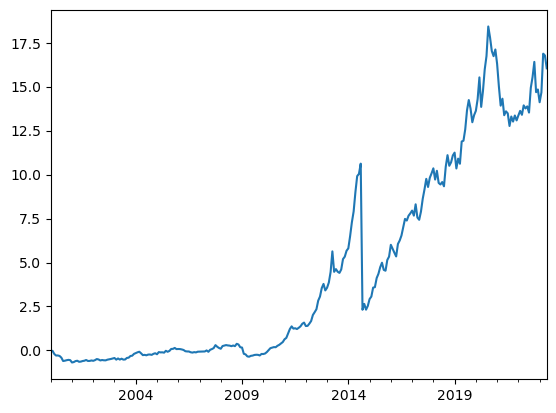

In [20]:
((mom_pnl.loc['2000-01':].iloc[:,0].dropna()+1).cumprod()-1).plot()

### 기본 모멘텀 분위별 결과 뽑기

In [170]:
# 8분위로? 10분위로?

# 10 decile의 경우

for x in zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]):
    print( x[0], x[1] )

0.9 1.0
0.8 0.9
0.7000000000000001 0.8
0.6000000000000001 0.7000000000000001
0.5 0.6000000000000001
0.4 0.5
0.30000000000000004 0.4
0.2 0.30000000000000004
0.1 0.2
0.0 0.1


In [24]:
mom_ret_filtered     = mom_ret.loc['1999':]
monthly_ret_filtered = df_ret.loc['1999':]

reg_table = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

for decile_num, x in (enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):
    
    decile_num = decile_num+1
    low_line, up_line = x[0], x[1]
    
    pnl_ret_list  = []
    ivst_idx_list = []
    long_tick_list = []
    short_tick_list = []
    s_ret_list = []
    l_ret_list = []

    for num in range(len(mom_ret_filtered)-1):
        series = mom_ret_filtered.iloc[num]

        date_idx = series.name
        ivst_idx = monthly_ret_filtered.index[np.where(monthly_ret_filtered.index==date_idx)[0][0] + 1]

        long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
        short_tick = series[series < series.quantile(0.1)].index.to_list()
        #short_tick = series[series < series.quantile(0.2)].index.to_list()

        long_ret = monthly_ret_filtered.loc[ivst_idx, long_tick].mean()
        short_ret = monthly_ret_filtered.loc[ivst_idx, short_tick].mean()
            
        pnl_ret = long_ret - 0 #- short_ret
            
        pnl_ret_list.append(pnl_ret)
        ivst_idx_list.append(ivst_idx)
        long_tick_list.append(long_tick)
        short_tick_list.append(short_tick)
        s_ret_list.append(short_ret)
        l_ret_list.append(long_ret)
        

    mom_pnl_filtered = pd.DataFrame(index=ivst_idx_list, \
                        data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                        columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

    cum_ret = ((mom_pnl_filtered.iloc[:,0]+1).cumprod()-1)[-1]
    ann_ret = np.round(mom_pnl_filtered.iloc[:,0].mean() * 12 * 100, 2)
    ann_std = np.round(mom_pnl_filtered.iloc[:,0].std() * np.sqrt(12) * 100, 2)
    
    sharpe = ((mom_pnl_filtered.iloc[:,[0]] - rf.loc[mom_pnl_filtered.index].apply(lambda x: x/12).to_numpy()).mean()/mom_pnl_filtered.iloc[:,[0]].std()).item()
    
    reg_table.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]

In [25]:
reg_table

,CumRet,AnnRet(%),AnnStd(%),sharpe
1,6.824742,12.64,28.83,0.093141
2,44.98237,18.74,24.35,0.182562
3,135.825852,23.09,23.51,0.242436
4,87.17643,21.0,22.34,0.22823
5,42.536527,18.23,23.12,0.185867
6,12.843996,13.05,20.98,0.13357
7,16.36988,14.22,22.02,0.142567
8,8.855331,12.54,24.91,0.106586
9,7.69634,12.39,26.35,0.099164
10,-0.37694,4.5,37.15,0.009011


# SMB, HML Port로 비교

먼저 small, big, growth 등 나누기

인덱스 설정 (1999-01-01)

In [26]:
time_idx = monthly_ret.loc['1996-01-01':].index

m_ret = monthly_ret.loc[time_idx]

In [27]:
value_ratio = df_eq.resample('m').last() / df_cap.resample('m').last()

'''Cap의 중간'''
small = df_cap.resample('m').last().apply(lambda x: x[x<x.median()].index.to_list(), axis=1).dropna().loc[time_idx]
big = df_cap.resample('m').last().apply(lambda x: x[x>x.median()].index.to_list(), axis=1).dropna().loc[time_idx]

'''가치는 equity/cap 한 것을 가지고 만듦'''
growth = value_ratio.apply(lambda x: x[x<x.quantile(0.3)].index.to_list(), axis=1).dropna().loc[time_idx]
neutral = value_ratio.apply(lambda x: x[(x>=x.quantile(0.3))& x<x.quantile(0.7)].index.to_list(), axis=1).dropna().loc[time_idx]
value = value_ratio.apply(lambda x: x[x>=x.quantile(0.7)].index.to_list(), axis=1).dropna().loc[time_idx]

In [28]:
small.head()

1996-01-31    [001570, 008930, 005850, 006280, 006110, 00942...
1996-02-29    [001570, 008930, 005850, 006280, 006110, 00942...
1996-03-31    [001570, 008930, 005850, 006280, 006110, 00942...
1996-04-30    [001570, 008930, 005850, 006280, 006110, 00942...
1996-05-31    [001570, 008930, 005850, 006280, 006110, 00942...
Freq: M, dtype: object

In [30]:
from tqdm import tqdm

print(set(small.index) - set(m_ret.index))
'''위에 공집합이여야, 아래 돌아감'''

set()


'위에 공집합이여야, 아래 돌아감'

In [31]:
SMB_list = []
HML_list = []

for idx in tqdm(m_ret.index):

    bv = m_ret.loc[idx].loc[list(set(big.loc[idx]) & set(value.loc[idx]))].mean()
    bn = m_ret.loc[idx].loc[list(set(big.loc[idx]) & set(neutral.loc[idx]))].mean()
    bg = m_ret.loc[idx].loc[list(set(big.loc[idx]) & set(growth.loc[idx]))].mean()
    sv = m_ret.loc[idx].loc[list(set(small.loc[idx]) & set(value.loc[idx]))].mean()
    sn = m_ret.loc[idx].loc[list(set(small.loc[idx]) & set(neutral.loc[idx]))].mean()
    sg = m_ret.loc[idx].loc[list(set(small.loc[idx]) & set(growth.loc[idx]))].mean()

    SMB = (sv+sn+sg)/3 - (bv+bn+bg)/3
    HML = (sv+bv)/2 - (sg+bg)/2
    
    SMB_list.append(SMB)
    HML_list.append(HML)


100%|██████████| 329/329 [00:00<00:00, 469.80it/s]


## SMB, HML 집합 비교하고, RP, rf 추가

In [32]:
rf = pd.read_csv('./DATA/CD91.csv', index_col=0, parse_dates=True).apply(lambda x : x/100).resample('m').last()

SMB = pd.DataFrame(SMB_list, index=m_ret.index, columns=['SMB']).dropna().loc[rf.index[0]:]
SMB = pd.DataFrame(pd.concat([SMB, rf], axis=1).dropna().apply(lambda x: x[0]-x[1]/12, axis=1), columns=['SMB'])

HML = pd.DataFrame(HML_list, index=m_ret.index, columns=['HML']).dropna().loc[rf.index[0]:]
HML = pd.DataFrame(pd.concat([HML, rf], axis=1).dropna().apply(lambda x: x[0]-x[1]/12, axis=1), columns=['HML'])

rf = rf.loc[SMB.index]

mkt = pd.read_csv('./DATA/kospi_index.csv', index_col=0, parse_dates=True).resample('m').last().pct_change().loc[SMB.index]
mkt = pd.DataFrame(pd.concat([mkt, rf], axis=1).dropna().apply(lambda x: x[0]-x[1]/12, axis=1), columns=['MKT'])

# Rolling Regression

In [33]:
resid_list = []

for name in tqdm(m_ret.columns):

    aa = name
    exret = pd.DataFrame(pd.concat([m_ret[aa], rf],axis=1).dropna().apply(lambda x: x[0] - x[1], axis=1), columns=['ExRet'])


    '''전체기간용'''
    setup_df = pd.concat([exret, mkt, SMB, HML], axis=1).dropna().iloc[35:]
    
    '''t-1~t-36롤링용'''
    setup_df_for_roll = pd.concat([exret, mkt, SMB, HML], axis=1).dropna().shift(1).dropna()
    
    y = setup_df_for_roll.iloc[:,[0]]
    y_real = setup_df.iloc[:,[0]]
    x = sm.add_constant(setup_df_for_roll.iloc[:, 1:])
    
    try:
        reg = RollingOLS(y, x, 35).fit()

        coef_df = reg.params

        resid = (y_real - pd.DataFrame(np.diag(np.dot(setup_df,coef_df.T)), index=setup_df.index, columns=['PRED']).values).rename(columns={'ExRet':aa})
        resid_list.append(resid)

    except:
        
        resid = pd.DataFrame(index=setup_df.index, columns=[aa])
        resid_list.append(resid)
        pass
    
resid_df = pd.concat(resid_list, axis=1)

resid_standard = resid_df.apply(lambda x: x.dropna().shift(1).rolling(11).sum()/x.dropna().shift(1).rolling(11).std(), axis=0)
resid_df

100%|██████████| 1102/1102 [00:17<00:00, 63.41it/s] 


,005930,373220,000660,207940,051910,006400,005380,035420,000270,005490,...,114410,117930,121910,122290,122750,138250,144620,152330,192520,192530
1998-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,-0.021617,NaN,0.068916,-0.228816,0.076867,0.090832,-0.007509,0.013445,-0.007844,-0.027602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28,-0.024640,NaN,-0.016572,-0.076052,-0.051938,-0.018421,0.055989,-0.026783,0.124292,0.050489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,0.019254,NaN,-0.049915,-0.152192,0.016491,0.035802,0.083839,-0.187527,0.107126,0.178367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-30,-0.014406,NaN,-0.016588,-0.083903,0.046166,-0.092350,0.018810,-0.080479,0.014078,-0.010221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


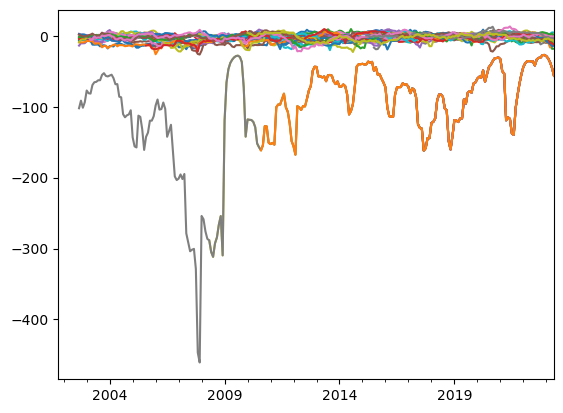

In [34]:
for x in resid_standard.columns[0:50]:
    resid_standard[x].plot()

시간별 정규화

In [ ]:
# '''Time Series Standardize'''
# resid_df_stan_t = resid_df.apply(lambda x: (x-x.mean())/x.std(), axis=1)
# for x in resid_df_stan_t.columns[0:50]:
#     resid_df_stan_t[x].plot()

기업별 정규화

In [ ]:
# '''cross sectional standardize'''
# resid_df_stan_f = resid_df.apply(lambda x: (x-x.mean())/x.std(), axis=0)
# for x in resid_df_stan_f.columns[0:50]:
#     resid_df_stan_f[x].plot()

# Residual Portfolio 만들기

t-1 ~ t-12의 residual 변화분을가지고 rank, 상위 10% 롱, 하위 10% 숏

2004년부터 진행됨..? 36이니, 3년 빼면.. 맞는거같기도

In [256]:
resid_mom_ret_list_1 = []
resid_mom_ret_date_list_1 = []
top_resid_num = []

monthly_resid = resid_standard.iloc[np.where(resid_standard.sum(axis=1) != 0)].iloc[:-1]
monthly_ret = m_ret.iloc[:-1]

for sig_index in tqdm(monthly_resid.index[:-1]):
    
    '''시그널 날짜'''
    sig_index = sig_index
    
    '''투자 수익률 날짜'''
    invest_index = monthly_ret.index[np.where(monthly_ret.index == sig_index)[0] + 1][0]
    
    '''편의를 위해'''
    series = monthly_resid.loc[sig_index]
    '''종목 선정'''
    long_tick   = series[series>=series.quantile(0.9)].index
    short_tick  = series[series<=series.quantile(0.1)].index

    '''수익률 (eq weight)'''
    long_ret    = m_ret.loc[invest_index, long_tick].mean()
    short_ret   = m_ret.loc[invest_index, short_tick].mean()

    '''mom_port_ret'''
    mom_port_ret = long_ret #- short_ret

    '''저장'''
    resid_mom_ret_date_list_1.append(invest_index)
    resid_mom_ret_list_1.append(mom_port_ret)

    '''이외 디버깅'''
    top_resid_num.append(len(long_tick))


100%|██████████| 248/248 [00:00<00:00, 1026.28it/s]


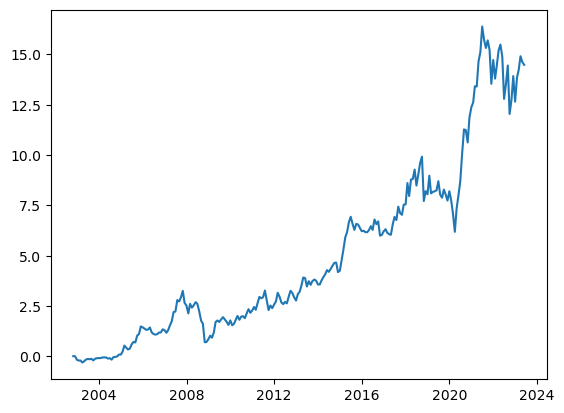

In [257]:
resid_mom_ret = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom Return?']).dropna()
plt.plot((resid_mom_ret + 1).cumprod()-1)

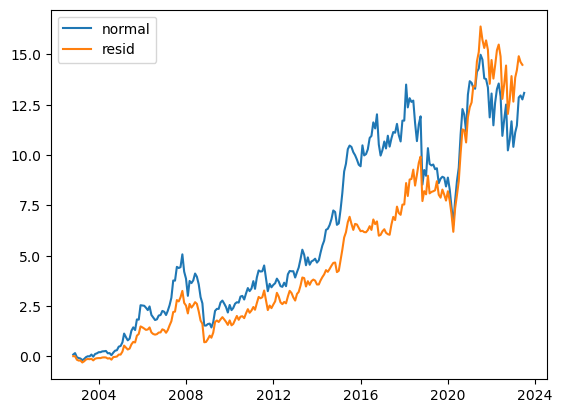

In [259]:
plt.plot(((mom_pnl_filtered.iloc[:,0].loc[resid_mom_ret.index[0]:]+1).cumprod()-1), label='normal')
plt.plot((resid_mom_ret + 1).cumprod()-1, label='resid')
plt.legend()

In [232]:
mom_ret_filtered     = df_close_filtered.shift(1).pct_change(11).iloc[12:].replace(0, np.NaN).loc['1999':]
monthly_ret_filtered = df_close_filtered.pct_change().iloc[1:].replace(0, np.NaN).loc['1999':]

reg_table = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

for decile_num, x in tqdm(enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):
    
    decile_num = decile_num+1
    low_line, up_line = x[0], x[1]
    
    pnl_ret_list  = []
    ivst_idx_list = []
    long_tick_list = []
    short_tick_list = []
    s_ret_list = []
    l_ret_list = []

    for num in range(len(mom_ret_filtered)-1):
        series = mom_ret_filtered.iloc[num]

        date_idx = series.name
        ivst_idx = monthly_ret_filtered.index[np.where(monthly_ret_filtered.index==date_idx)[0][0] + 1]

        long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
        short_tick = series[series < series.quantile(0.1)].index.to_list()
        #short_tick = series[series < series.quantile(0.2)].index.to_list()

        long_ret = monthly_ret_filtered.loc[ivst_idx, long_tick].mean()
        short_ret = monthly_ret_filtered.loc[ivst_idx, short_tick].mean()
            
        pnl_ret = long_ret - 0 #- short_ret
            
        pnl_ret_list.append(pnl_ret)
        ivst_idx_list.append(ivst_idx)
        long_tick_list.append(long_tick)
        short_tick_list.append(short_tick)
        s_ret_list.append(short_ret)
        l_ret_list.append(long_ret)
        

    mom_pnl_filtered = pd.DataFrame(index=ivst_idx_list, \
                        data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                        columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

    cum_ret = ((mom_pnl_filtered.iloc[:,0]+1).cumprod()-1)[-1]
    ann_ret = np.round(mom_pnl_filtered.iloc[:,0].mean() * 12 * 100, 2)
    ann_std = np.round(mom_pnl_filtered.iloc[:,0].std() * np.sqrt(12) * 100, 2)
    
    sharpe = ((mom_pnl_filtered.iloc[:,[0]] - rf.loc[mom_pnl_filtered.index].apply(lambda x: x/12).to_numpy()).mean()/mom_pnl_filtered.iloc[:,[0]].std()).item()
    
    reg_table.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]

,Residual Mom Return?
2002-10-31,0.067989
2002-11-30,-0.005535
2002-12-31,-0.185104
2003-01-31,-0.042268
2003-02-28,-0.008951
...,...
2023-01-31,0.087590
2023-02-28,0.025113
2023-03-31,0.040563
2023-04-30,-0.014980


resid